<a href="https://colab.research.google.com/github/ajeyamk/ds-5230-uml/blob/master/enron_final_ajeya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Pre-Trained BERT

In [5]:
!pip install transformers

     |████████████████████████████████| 778kB 5.3MB/s 
     |████████████████████████████████| 890kB 27.5MB/s 
     |████████████████████████████████| 3.0MB 51.4MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b5ae19562b2f1de5251b84ff035d24801d21bea8e658076297d56ac3b5b7187a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
if torch.cuda.is_available():
  device=torch.device("cuda")
  print("Yay I got a free GPU:", torch.cuda.get_device_name(0))

else:
  print("No GPU")
  device=torch.device("cpu")

Yay I got a free GPU: Tesla K80


In [3]:
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
% matplotlib inline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
##Establishing data connection
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#Parse data
import pandas as pd
email= pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/train-sent.csv")

In [7]:
email.head()

,Unnamed: 0,e_id,email_body,subject_line,user
0,0,_161.subject,"Wade, I understood your number one priority ...",For Wade,allen-p
1,1,_251.subject,"Will, Here is a list of the top items we nee...",Priority List,allen-p
2,2,_3.subject,"Christy, I read these points and they defini...",Talking points about California Gas market,allen-p
3,3,_50.subject,"Jed, I understand you have been contacted re...",Enron,allen-p
4,4,_500.subject,"Griff, Can you accomodate Dexter as we have...",NGI access to eol,allen-p


In [5]:
# sent_email_data = pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/train-sent.csv")
# received_email_data = pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/train-received.csv")
import pandas as pd
email_train_sent= pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/train-sent.csv")
email_train_rec= pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/train-received.csv")
email_dev_sent= pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/dev-sent.csv")
email_dev_rec= pd.read_csv("/content/drive/My Drive/data-science/UML/enron_subject_line/dev-received.csv")

In [6]:
master_df = pd.concat([email_train_sent, email_train_rec, email_dev_sent,email_dev_rec])

In [8]:
len(master_df.user.unique())

144

In [11]:
master_df.head().drop(['Unnamed: 0'], axis=1)

,e_id,email_body,subject_line,user
0,_161.subject,"Wade, I understood your number one priority ...",For Wade,allen-p
1,_251.subject,"Will, Here is a list of the top items we nee...",Priority List,allen-p
2,_3.subject,"Christy, I read these points and they defini...",Talking points about California Gas market,allen-p
3,_50.subject,"Jed, I understand you have been contacted re...",Enron,allen-p
4,_500.subject,"Griff, Can you accomodate Dexter as we have...",NGI access to eol,allen-p


## People of interest from the case





http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm

* Lay, Kenneth
* Skilling, Jeffrey
* Forney, John
* Delainey, David

* Glisan, Ben
* Richter, Jeffrey
* Lawyer, Larry
* Belden, Timothy
* Kopper, Michael
* Duncan, David
* Bowen, Raymond
* Colwell, Wesley
* Boyle, Dan
* Loehr, Christopher
* Howard, Kevin
* Krautz, Michael
* Yeager, Scott
* Hirko, Joseph
* Shelby, Rex
* Bermingham, David
* Darby, Giles
* Mulgrew, Gary
* Bayley, Daniel
* Brown, James
* Furst, Robert
* Fuhs, William
* Causey, Richard
* Calger, Christopher
* DeSpain, Timothy
* Hannon, Kevin
* Koenig, Mark
* Rice, Kenneth
* Rieker, Paula
* Fastow, Lea
* Fastow, Andrew

In [12]:
# From the internet we found the prominent people involved in the fiasco
persons_of_interest = [
                       'lay-k', #ceo
                       'skilling-j', #next-ceo
                       'lavorato-j', #received-huge-bonuses
                       'whalley-g',
                       'lavorato-j'
]

poi_df = master_df[master_df.user.isin(persons_of_interest)]
print(poi_df.shape)

# Rest of the employees
normal_people_df = master_df[~master_df.user.isin(persons_of_interest)]
normal_people_df = normal_people_df.sample(frac=0.25, replace=True, random_state=1)
print(normal_people_df.shape)

(1209, 5)
(3797, 5)


In [139]:
normal_people_df.head()

,Unnamed: 0,e_id,email_body,subject_line,user
8054,8054,_3.subject,"Hi John, As per our conversation last we...",UBS,zufferli-j
235,235,_651.subject,Does the info as provided from HR indicate MBA...,Alumni List,beck-s
6761,6761,_61.subject,Please ask your schedulers to e-mail me which ...,Pipeline Dial Up access,staab-t
5234,5234,_5507.subject,I am reviewing comments from our Tuesday meeti...,"Koch Pipelines Canada, L.P. (""Koch"")",shackleton-s
905,905,_259.subject,"Guys, what are we going to do with this contra...",LIPA,delainey-d


# Naive clustering approach with count vectorizer 

In [13]:
df = normal_people_df

# Lets vectorize the corpus
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
def _naive_clustering(df, slice_loc):
  stopwords = ENGLISH_STOP_WORDS
  my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                          'forwarded', 'corp', 'said', 'attached', 'ect',\
                                          'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                          'enronxgate', 'na', 'year'])

  count_vectorizer = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)

  # vectorizer = TfidfVectorizer(stop_words='english')
  vectorizer = count_vectorizer.fit_transform(df['email_body']) # this is my sparce matrix

  # Dense vector constructor
  cv_dense_vector = pd.DataFrame(vectorizer.toarray(), columns=count_vectorizer.get_feature_names())
  print(cv_dense_vector.head())

  # checking where the unwanted columns end
  #62 for poidf
  #76 for normal_df
  print(cv_dense_vector.iloc[:,slice_loc:].head(1))

  # lets drop those columns
  cv_dense_vector = cv_dense_vector.drop(cv_dense_vector.iloc[:, 0:slice_loc], axis = 1)

  print(cv_dense_vector.shape)
  print(cv_dense_vector.head())

  segments = list(range(2,10))
  for x in segments:
      _fit_kmeans(cv_dense_vector, x)

  cv_dense_vector.sum().sort_values(ascending=False).head(80).plot(kind='barh',
                                                                    figsize=(20,20),
                                                                    fontsize=16,
                                                                    title='Frequently Occuring Words');
  return count_vectorizer, cv_dense_vector


In [178]:
cv_dense_vector.iloc[:,76:].head(1)

,abb,ability,able,absence,accept,acceptable,accepted,access,according,accordingly,account,accounting,accounts,accurate,acknowledge,acquire,acrobat,act,action,actions,active,activities,activity,actual,actually,add,added,adding,addition,additional,additionally,address,addressed,adequate,adjustment,adjustments,administration,adobe,advance,advantage,...,welcome,went,west,western,whalley,white,wholesale,williams,willing,win,wind,window,windows,winter,wish,withdrawals,won,wonderful,word,words,work,worked,working,works,worksheet,world,worth,wouldn,write,writes,writing,written,wrong,www,years,yes,yesterday,york,zero,zone
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
def _best_kmeans(n_clusters, dense_vector, vectorizer):
  #picking the best model 
  # best silhouette score 
  best_naive_kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=1, verbose=1)
  best_naive_kmeans.fit(dense_vector)
  best_naive_kmeans_centroids = best_naive_kmeans.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer.get_feature_names()

  for i in range(n_clusters):
    print('********* Cluster d:', i, '**************'),
    for ind in best_naive_kmeans_centroids[i, :20]:
      print(' ', terms[ind])

   00  000  01  02  03  04  05  ...  www  years  yes  yesterday  york  zero  zone
0   0    0   0   0   0   0   0  ...    0      1    0          0     0     0     0
1   0    0   0   0   0   0   0  ...    0      0    0          0     0     0     0
2   0    0   0   0   0   0   0  ...    0      0    0          0     0     0     0
3   0    0   1   0   0   0   0  ...    0      0    0          0     0     0     0
4   0    0   0   0   0   0   0  ...    0      0    0          0     0     0     0

[5 rows x 2000 columns]
   abb  ability  able  absence  accept  ...  yes  yesterday  york  zero  zone
0    0        0     0        0       0  ...    0          0     0     0     0

[1 rows x 1924 columns]
(3797, 1924)
   abb  ability  able  absence  accept  ...  yes  yesterday  york  zero  zone
0    0        0     0        0       0  ...    0          0     0     0     0
1    0        0     0        0       0  ...    0          0     0     0     0
2    0        1     0        0       0  ...    0       

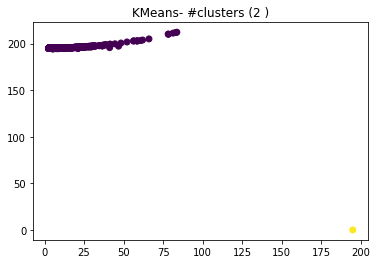

For n_clusters = 3 The average silhouette_score is : 0.8638792185014149
For n_clusters = 3 The CH score is : 409.0334264568764


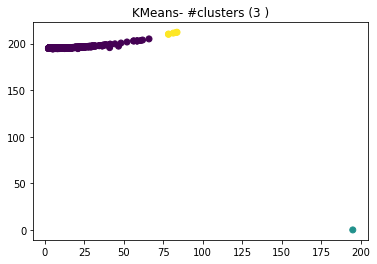

For n_clusters = 4 The average silhouette_score is : 0.8147566666833863
For n_clusters = 4 The CH score is : 322.5278609845064


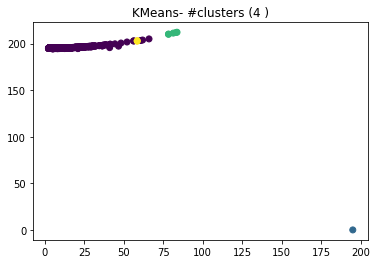

For n_clusters = 5 The average silhouette_score is : 0.5786840248985488
For n_clusters = 5 The CH score is : 255.93927005438172


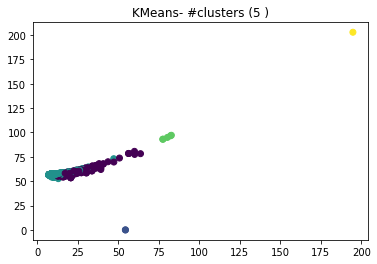

For n_clusters = 6 The average silhouette_score is : 0.5359096057931375
For n_clusters = 6 The CH score is : 204.08998412637314


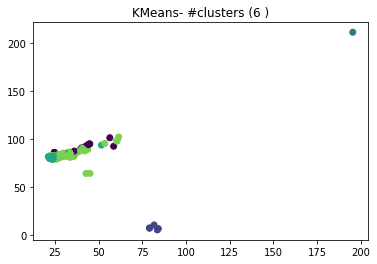

For n_clusters = 7 The average silhouette_score is : 0.5319170221874803
For n_clusters = 7 The CH score is : 191.51973405315346


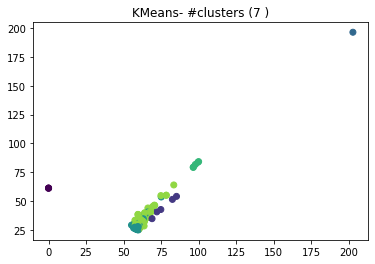

For n_clusters = 8 The average silhouette_score is : 0.3410646702918858
For n_clusters = 8 The CH score is : 171.30337287990676


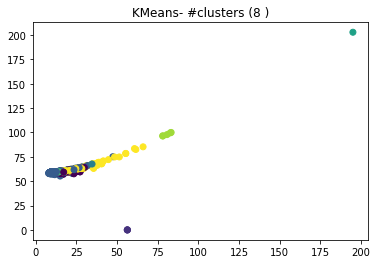

For n_clusters = 9 The average silhouette_score is : 0.5327951457046062
For n_clusters = 9 The CH score is : 171.1319815848324


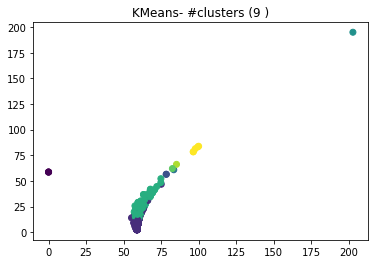

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 392949.220727848
start iteration
done sorting
end inner loop
Iteration 1, inertia 382470.5884138295
start iteration
done sorting
end inner loop
Iteration 2, inertia 368386.9122416653
start iteration
done sorting
end inner loop
Iteration 3, inertia 364764.37467018457
start iteration
done sorting
end inner loop
Iteration 4, inertia 364764.37467018457
center shift 0.000000e+00 within tolerance 5.441630e-06
********* Cluster d: 0 **************
  cell
  status
  title
  timing
  greatly
  covers
  demand
  hold
  physical
  transferred
  opening
  pat
  59
  rate
  skills
  person
  site
  mean
  greg
  keeping
********* Cluster d: 1 **************
  individuals
  steve
  means
  involved
  materials
  fares
  study
  item
  40
  pre
  haven
  litigation
  participate
  cause
  consumed
  inconvenience
  auction
  computer
  contacts
  directly
********* Cluster d: 2 **************
  additional
  let
 

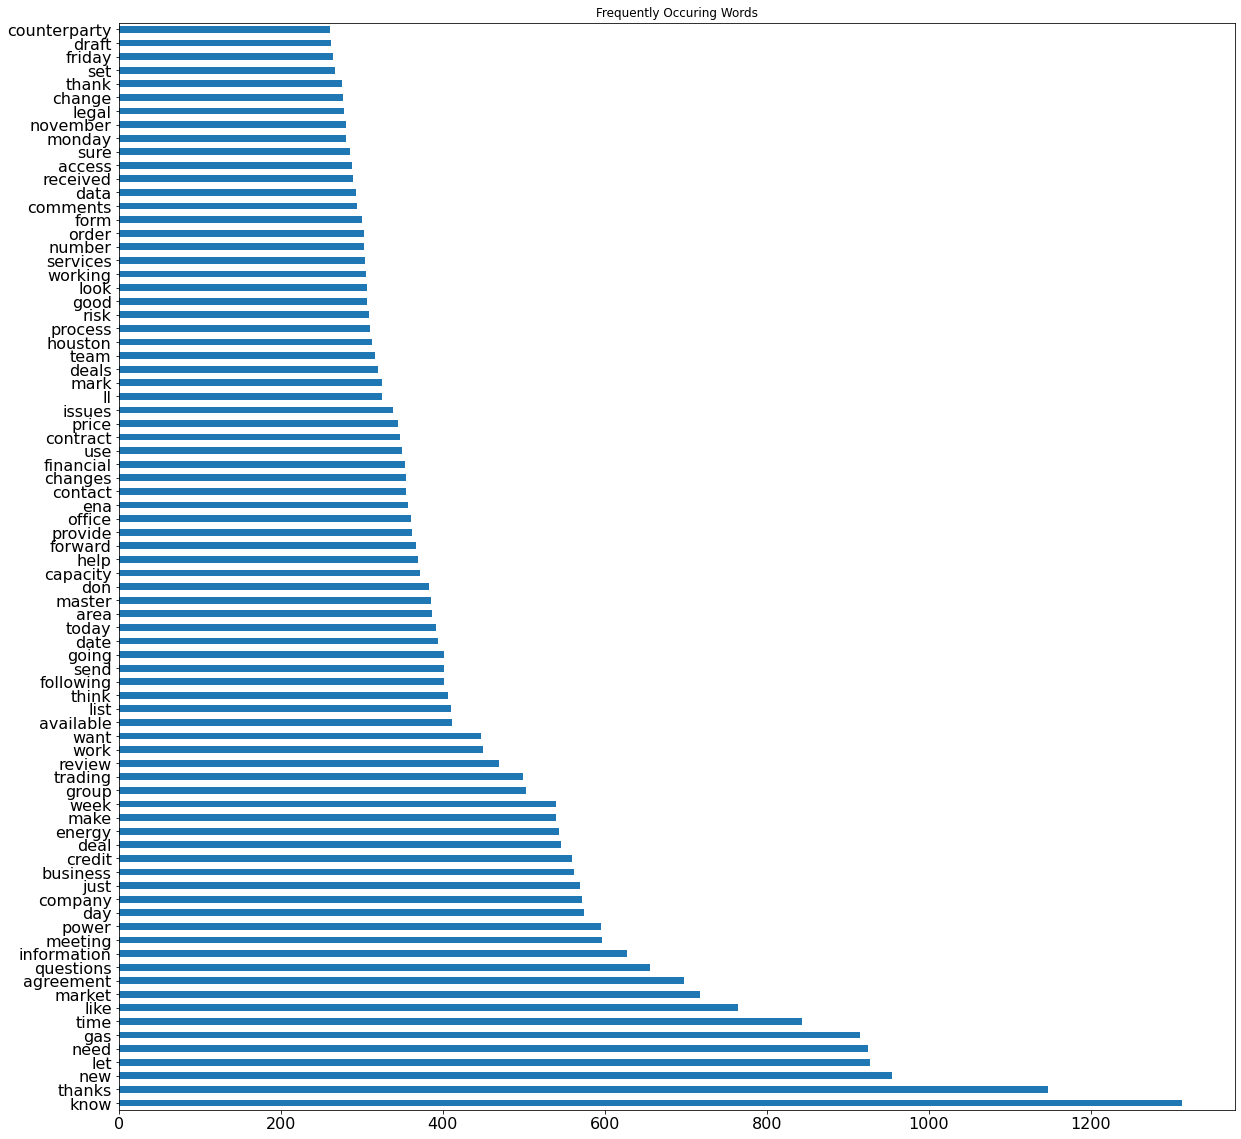

In [20]:
# Person of interest cluster
count_vectorizer, cv_dense_vector = _naive_clustering(normal_people_df, 76)
_best_kmeans(3, cv_dense_vector, count_vectorizer)

   00  000  01  02  03  04  07  ...  years  yes  yesterday  yield  york  young  ypo
0   0    0   0   0   0   0   0  ...      0    0          0      0     0      0    0
1   0    0   0   0   0   0   0  ...      0    0          0      0     0      0    0
2   0    0   0   0   0   0   0  ...      0    0          0      0     0      0    0
3   0    0   0   0   0   0   0  ...      0    0          0      0     0      0    0
4   1    0   0   0   0   0   0  ...      0    0          0      0     0      0    0

[5 rows x 2000 columns]
   853  8th  90  ability  able  ...  yesterday  yield  york  young  ypo
0    0    0   0        0     0  ...          0      0     0      0    0

[1 rows x 1938 columns]
(1209, 1938)
   853  8th  90  ability  able  ...  yesterday  yield  york  young  ypo
0    0    0   0        0     0  ...          0      0     0      0    0
1    0    0   0        0     0  ...          0      0     0      0    0
2    0    0   0        0     0  ...          0      0     0      0    0
3

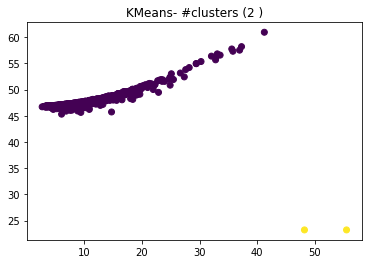

For n_clusters = 3 The average silhouette_score is : 0.5314338355901447
For n_clusters = 3 The CH score is : 30.609595090513185


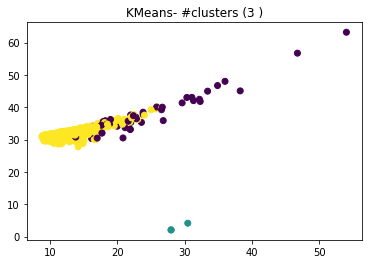

For n_clusters = 4 The average silhouette_score is : 0.31791819864046894
For n_clusters = 4 The CH score is : 34.79801293667001


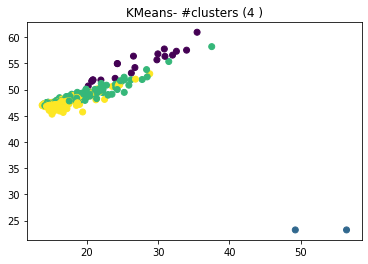

For n_clusters = 5 The average silhouette_score is : 0.400564446729627
For n_clusters = 5 The CH score is : 30.49297284549276


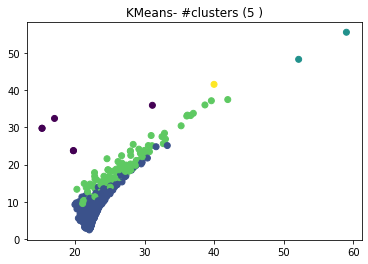

For n_clusters = 6 The average silhouette_score is : 0.3220074529465233
For n_clusters = 6 The CH score is : 28.490486532454042


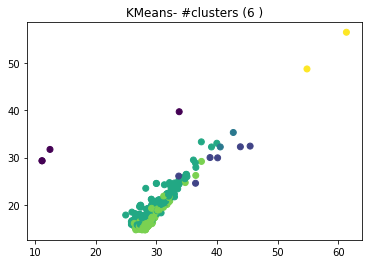

For n_clusters = 7 The average silhouette_score is : 0.38521811504619724
For n_clusters = 7 The CH score is : 22.646231327417237


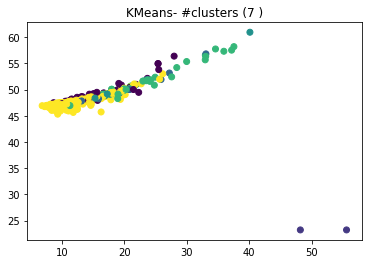

For n_clusters = 8 The average silhouette_score is : 0.26460230601324164
For n_clusters = 8 The CH score is : 22.517615632383496


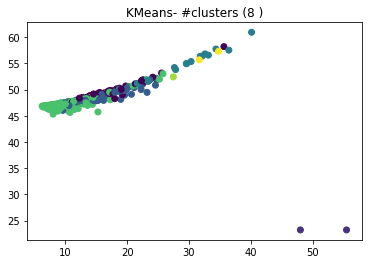

For n_clusters = 9 The average silhouette_score is : 0.3621194043951764
For n_clusters = 9 The CH score is : 22.853839533392915


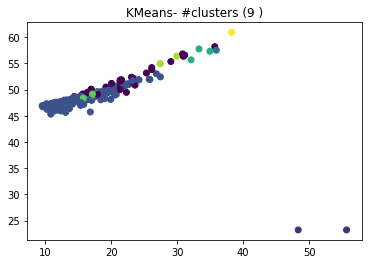

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 119313.19988312117
start iteration
done sorting
end inner loop
Iteration 1, inertia 116858.02445942581
start iteration
done sorting
end inner loop
Iteration 2, inertia 116118.75696910587
start iteration
done sorting
end inner loop
Iteration 3, inertia 115903.1940256044
start iteration
done sorting
end inner loop
Iteration 4, inertia 115800.61508137688
start iteration
done sorting
end inner loop
Iteration 5, inertia 115725.09356974042
start iteration
done sorting
end inner loop
Iteration 6, inertia 115647.40476771483
start iteration
done sorting
end inner loop
Iteration 7, inertia 115603.57481458654
start iteration
done sorting
end inner loop
Iteration 8, inertia 115566.99028320376
start iteration
done sorting
end inner loop
Iteration 9, inertia 115509.59206725018
start iteration
done sorting
end inner loop
Iteration 10, inertia 115487.69548788942
start iteration
done sorting
end inner loop
Iteratio

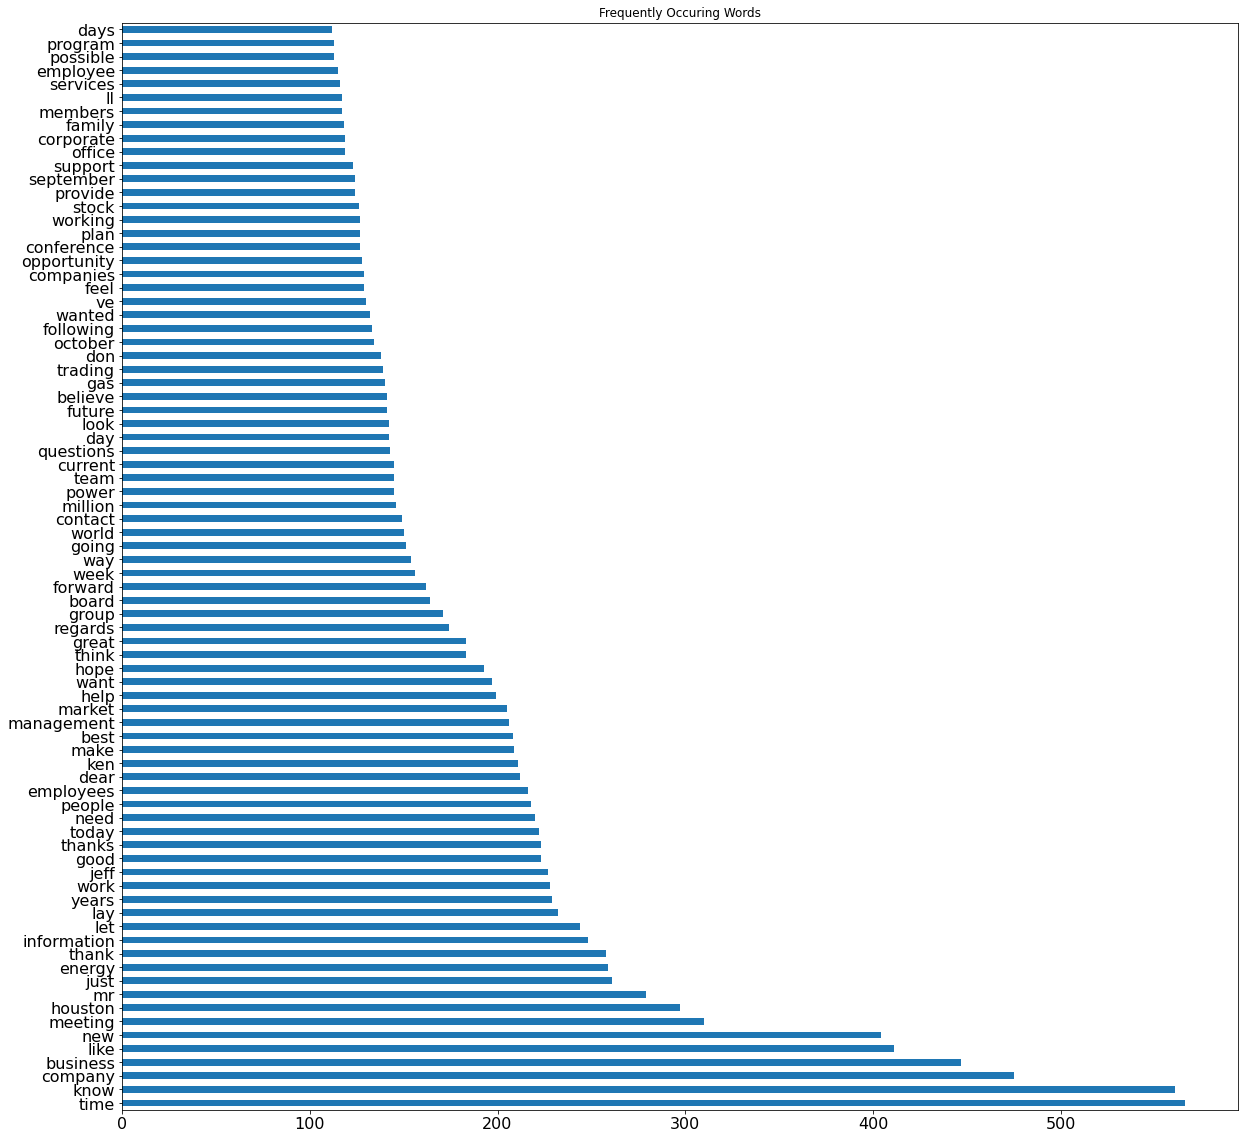

In [21]:
count_vectorizer, cv_dense_vector = _naive_clustering(poi_df, 62)
_best_kmeans(5, cv_dense_vector, count_vectorizer)

In [182]:
# Normal df
_best_kmeans(5, cv_dense_vector, count_vectorizer)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 320288.4947898786
start iteration
done sorting
end inner loop
Iteration 1, inertia 317975.92198067607
start iteration
done sorting
end inner loop
Iteration 2, inertia 317806.3310347108
start iteration
done sorting
end inner loop
Iteration 3, inertia 317806.3310347108
center shift 0.000000e+00 within tolerance 5.426762e-06
********* Cluster d: 0 **************
  fernley
  derivatives
  consulting
  task
  limited
  nation
  contract
  consumed
  park
  dispute
  simply
  letter
  password
  remember
  tonight
  maximum
  confidentiality
  originals
  merger
  cgas
********* Cluster d: 1 **************
  instead
  students
  jan
  merger
  media
  summary
  joe
  fernley
  65
  president
  helpful
  location
  individual
  password
  cgas
  avoid
  legal
  understand
  controls
  confidentiality
********* Cluster d: 2 **************
  advice
  limited
  reduced
  announced
  negotiated
  expansion
  

In [28]:
def generate_encoding(df):
  input_ids= []
  lengths=[]
  for i in range(0,len(df.email_body)):
    encoded_email=tokenizer.encode(
                                    df.email_body.iloc[i], #Sentence to be encoded
                                    add_special_tokens = True #Adding cls and sep tokens
                                  )
    input_ids.append(encoded_email)
    lengths.append(len(encoded_email))
  return input_ids, lengths

In [32]:
input_ids, lengths = generate_encoding(email)

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [33]:
#Some descriptive stats for understanding the word length distributions
import numpy as np
print('Minimum length is', min(lengths))
print('Maximum length is', max(lengths))
print('Medium length is', np.median(lengths))

Minimum length is 29
Maximum length is 4774
Medium length is 80.0


In [18]:
#A plot to visualise the distribution of comment length

import matplotlib.pyplot as plt
import seaborn as sns
lengths=[min(l,512) for l in lengths] # to get a better scale on x axis and to see the distribution better
plt.rcParams["figure.figsize"] = (10,5)
sns.distplot(lengths,kde=False,rug=False)
plt.xlabel('Comment Length')
plt.ylabel("Comment count")
plt.title("Comment Length Distribution")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored

In [35]:
num_truncated = lengths.count(512)
num_sentences = len(lengths)
per= (float(num_truncated / num_sentences)) *100
print('{:,} of {:,} sentences {:,}% are longer than 512 in token length'.format(num_truncated,num_sentences,per))

112 of 6,374 sentences 1.7571383746470035% are longer than 512 in token length


So I think we can disregard these.

In [36]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model.output_hidden_states = True
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [37]:
from keras.preprocessing.sequence import pad_sequences

# A function to return embeddings given a text

def get_bert_embeddings(tokenizer,model,input):
  max_len=512
  
  input_ids=tokenizer.encode(
                             input,
                             add_special_tokens = True,
                             max_length = max_len,
                             truncation = True
                            )
  
  results= pad_sequences([input_ids], maxlen=max_len,dtype="long",truncating ="post",padding="post")
  input_ids = results[0]
  attn_masks = [int(i>0) for i in input_ids]
  input_ids = torch.tensor(input_ids)
  attn_masks = torch.tensor(attn_masks)
  input_ids = input_ids.unsqueeze(0)
  attn_masks = attn_masks.unsqueeze(0)
  model.eval()
  input_ids = input_ids.to(device)
  attn_masks = attn_masks.to(device)
  model=model.to(device)
  with torch.no_grad():

    logits,c,encoded_layers = model(
                                  input_ids=input_ids,
                                  attention_mask = attn_masks
                                 )
  
  layer_i = 12
  batch_i=0
  token_i=0

  vec = encoded_layers[layer_i][batch_i][token_i]
  vec=vec.detach().cpu().numpy()

  return(vec)

In [38]:
input = email.iloc[0].email_body
vec = get_bert_embeddings(tokenizer,model,input)
print(vec.shape)

(768,)


In [52]:
import time

def _get_feature_matrix(data, model=model, tokenizer=tokenizer, 
                        get_bert_embeddings=get_bert_embeddings):
  t0 = time.time()
  embeddings=[]
  row_num =0
  # email_body=email['email_body']

  for index , row in data.iterrows():
    if row_num % 1000 == 0 and not row_num == 0:
      elapsed =time.time() - t0
      print('Comment {:,} processed in time {:,}'.format(row_num,elapsed))
    vec=get_bert_embeddings(tokenizer, model, row.email_body)
    embeddings.append(vec)
    row_num +=1
  return embeddings

In [44]:
sent_email_data.user.unique()

array(['allen-p', 'arnold-j', 'arora-h', 'bass-e', 'beck-s', 'brawner-s',
       'buy-r', 'campbell-l', 'carson-m', 'cash-m', 'cuilla-m',
       'dasovich-j', 'davis-d', 'delainey-d', 'derrick-j', 'dickson-s',
       'donohoe-t', 'dorland-c', 'farmer-d', 'fischer-m', 'fossum-d',
       'gay-r', 'germany-c', 'giron-d', 'grigsby-m', 'haedicke-m',
       'hayslett-r', 'heard-m', 'hernandez-j', 'hodge-j', 'horton-s',
       'hyvl-d', 'jones-t', 'kaminski-v', 'kean-s', 'keavey-p',
       'kuykendall-t', 'lavorato-j', 'lay-k', 'lenhart-m', 'lewis-a',
       'lokay-m', 'love-p', 'mann-k', 'mcconnell-m', 'mckay-b',
       'mclaughlin-e', 'mims-thurston-p', 'neal-s', 'nemec-g',
       'pereira-s', 'perlingiere-d', 'presto-k', 'ring-a', 'rodrique-r',
       'rogers-b', 'ruscitti-k', 'sager-e', 'sanders-r', 'scott-s',
       'shackleton-s', 'shankman-j', 'shapiro-r', 'shively-h',
       'skilling-j', 'smith-m', 'south-s', 'stclair-c', 'sturm-f',
       'symes-k', 'taylor-m', 'tholt-j', 'tycholiz-

In [45]:
received_email_data.user.unique()

array(['allen-p', 'arnold-j', 'arora-h', 'bailey-s', 'bass-e',
       'baughman-d', 'beck-s', 'benson-r', 'blair-l', 'brawner-s',
       'buy-r', 'campbell-l', 'carson-m', 'cash-m', 'causholli-m',
       'corman-s', 'crandell-s', 'cuilla-m', 'dasovich-j', 'davis-d',
       'dean-c', 'delainey-d', 'derrick-j', 'donoho-l', 'donohoe-t',
       'dorland-c', 'ermis-f', 'farmer-d', 'fischer-m', 'forney-j',
       'gang-l', 'gay-r', 'geaccone-t', 'germany-c', 'gilbertsmith-d',
       'giron-d', 'griffith-j', 'grigsby-m', 'haedicke-m', 'harris-s',
       'hayslett-r', 'heard-m', 'hendrickson-s', 'hernandez-j', 'hodge-j',
       'holst-k', 'horton-s', 'hyatt-k', 'jones-t', 'kaminski-v',
       'kean-s', 'keavey-p', 'keiser-k', 'king-j', 'kitchen-l',
       'kuykendall-t', 'lavorato-j', 'lay-k', 'lenhart-m', 'lewis-a',
       'lokay-m', 'lokey-t', 'love-p', 'lucci-p', 'maggi-m', 'mann-k',
       'martin-t', 'may-l', 'mccarty-d', 'mcconnell-m', 'mckay-b',
       'mckay-j', 'mclaughlin-e', 'meyers

In [74]:
poi_sent_df = email_data[email_data.user.isin(persons_of_interest)]
print(poi_sent_df.shape)
poi_sent_df.head()

(78, 5)


,Unnamed: 0,e_id,email_body,subject_line,user
2883,2883,_129.subject,Dave The PPA schedule was pushed back two we...,Notification of Postponement,lavorato-j
2884,2884,_140.subject,The Emmisions book under Kevin McGowan will ta...,Emmisions,lavorato-j
2885,2885,_146.subject,Please excuse Kim Hillis and Kay Chapman from ...,SAP Timekeeping Class,lavorato-j
2886,2886,_147.subject,This memo follows up on our discussion this mo...,VAR,lavorato-j
2887,2887,_166.subject,"This is to confirm a meeting for tomorrow, Tue...",System Meeting 7/11,lavorato-j


In [184]:
poi_df_vectors = np.stack(_get_feature_matrix(poi_df))
poi_df_vectors.shape

Comment 1,000 processed in time 69.85207891464233


(1209, 768)

In [185]:
normal_people_df_vectors = np.stack(_get_feature_matrix(normal_people_df))
normal_people_df_vectors.shape

Comment 1,000 processed in time 69.84413361549377
Comment 2,000 processed in time 139.4519293308258
Comment 3,000 processed in time 209.1522901058197


(3797, 768)

In [186]:
master_df_vectors = np.load("/content/drive/My Drive/data-science/UML/enron_subject_line/embeddings_train_dev.npy")
master_df_vectors.shape

(16396, 768)

In [4]:
from sklearn.decomposition import PCA

def _fit_pca(data, components):
    """
    input: 
        data: feature matrix of the image 
        components: prominent components looking for in the data
    output: PCA model fitted on feature matrix
    """
    return PCA(n_components=components).fit(data)

def _scree_plot(variance_list):
    """
    Plots scree plot on the explained variance from the model 
    """
    plt.plot(np.cumsum(variance_list), label="Number of components(Image 2): {}".format(len(variance_list)))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.legend(loc="upper left")
    plt.show()

array([0.14643344], dtype=float32)


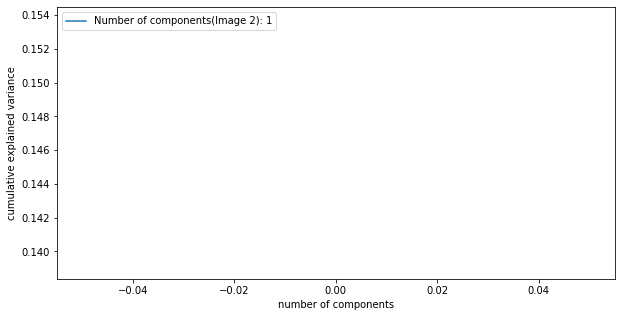

array([0.14643355, 0.10461058], dtype=float32)


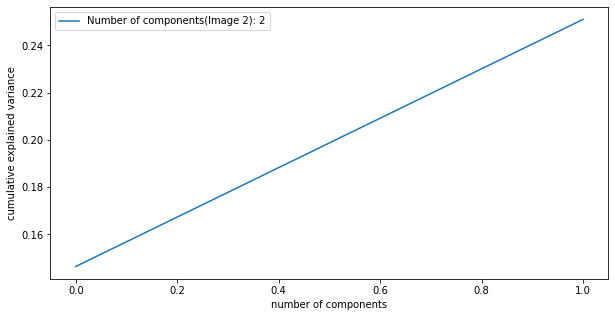

array([0.14643349, 0.10461071, 0.04886292], dtype=float32)


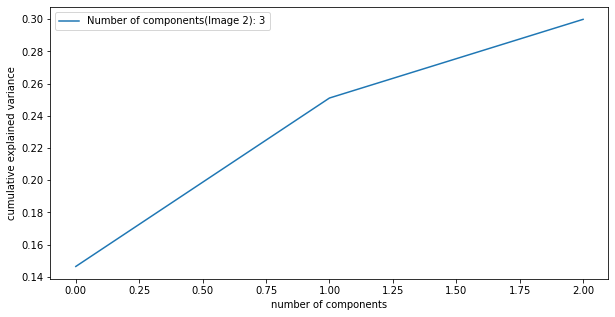

array([0.14643349, 0.10461067, 0.04886285, 0.03847042], dtype=float32)


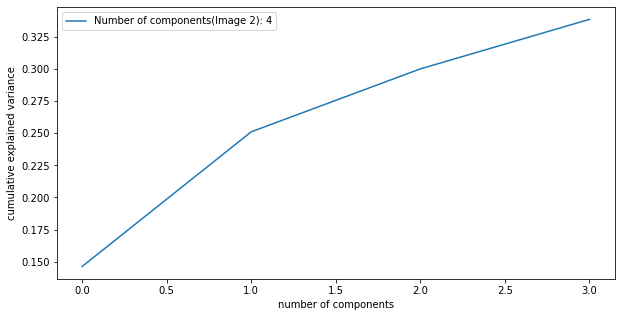

array([0.14643349, 0.10461054, 0.04886292, 0.0384704 , 0.03336883],
      dtype=float32)


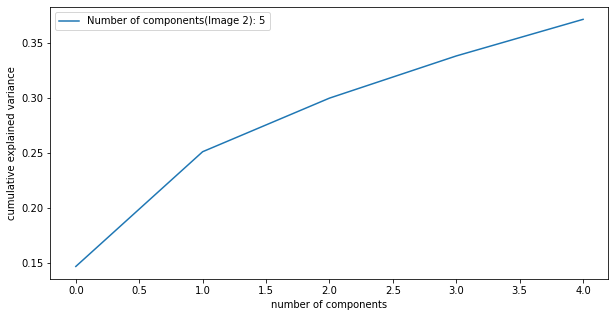

array([0.14643337, 0.10461065, 0.04886291, 0.03847051, 0.0333688 ,
       0.03059559], dtype=float32)


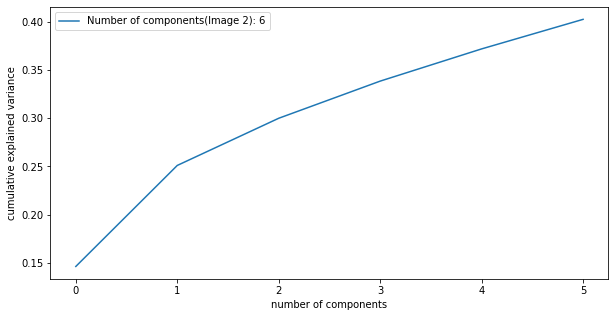

array([0.14643352, 0.10461065, 0.04886291, 0.03847048, 0.03336882,
       0.03059558, 0.02611563], dtype=float32)


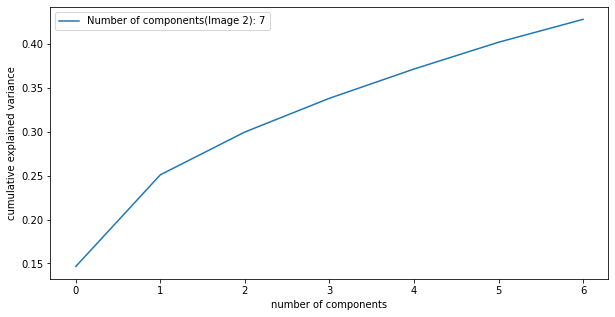

array([0.14643352, 0.10461065, 0.04886296, 0.03847044, 0.0333688 ,
       0.03059557, 0.02611565, 0.01844365], dtype=float32)


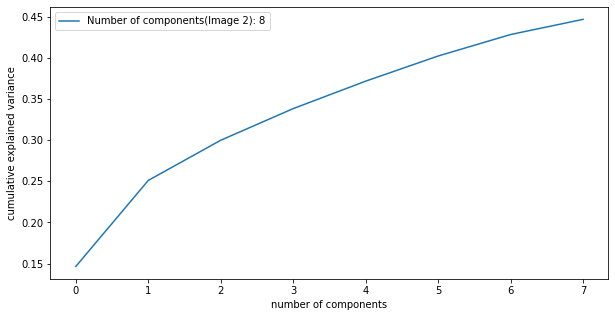

array([0.1464334 , 0.10461042, 0.04886289, 0.03847045, 0.03336881,
       0.0305956 , 0.02611564, 0.01844476, 0.01762126], dtype=float32)


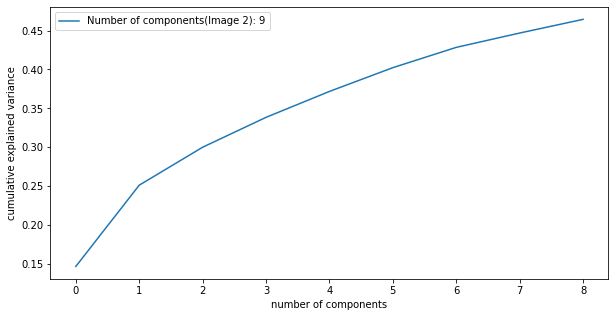

array([0.14643344, 0.10461054, 0.04886289, 0.03847047, 0.03336881,
       0.03059557, 0.02611564, 0.01844486, 0.0176212 , 0.0156562 ],
      dtype=float32)


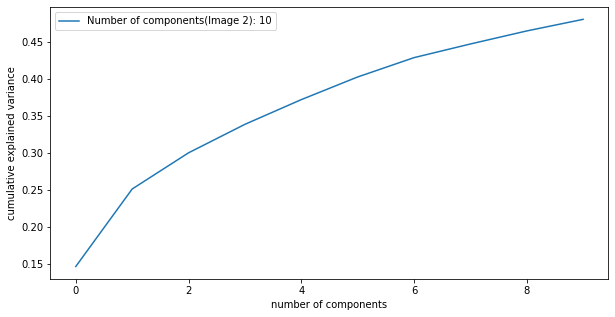

array([0.14643349, 0.10461058, 0.04886291, 0.03847042, 0.03336879,
       0.03059552, 0.02611564, 0.01844482, 0.01762099, 0.01565606,
       0.01525358], dtype=float32)


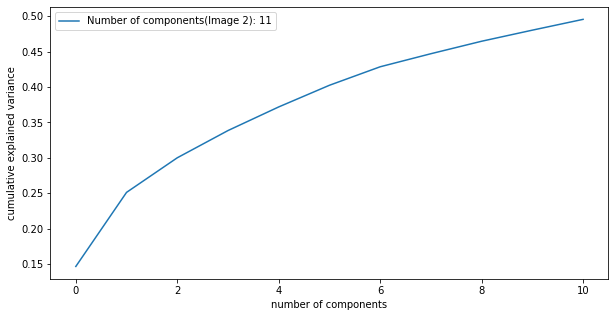

array([0.14643343, 0.10461054, 0.04886286, 0.03847042, 0.03336884,
       0.03059558, 0.02611566, 0.01844485, 0.01762129, 0.01565539,
       0.01525383, 0.01360789], dtype=float32)


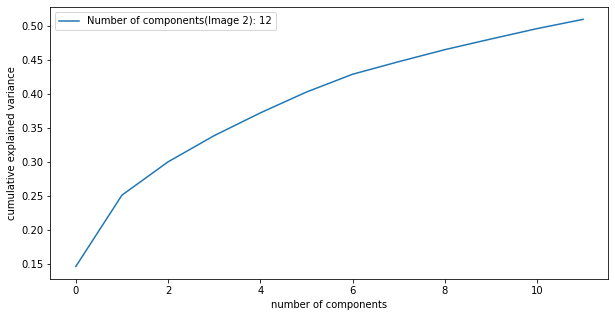

array([0.14643349, 0.10461046, 0.0488629 , 0.03847044, 0.03336881,
       0.0305956 , 0.02611563, 0.01844491, 0.01762134, 0.01565627,
       0.01525428, 0.01360798, 0.01258444], dtype=float32)


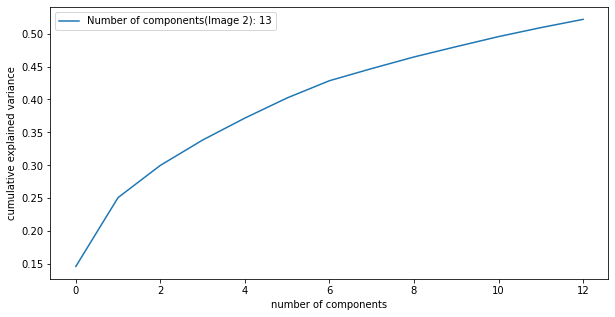

array([0.14643349, 0.10461056, 0.04886292, 0.03847046, 0.03336883,
       0.0305956 , 0.02611564, 0.01844486, 0.01762131, 0.0156563 ,
       0.01525445, 0.01360765, 0.01258486, 0.01179858], dtype=float32)


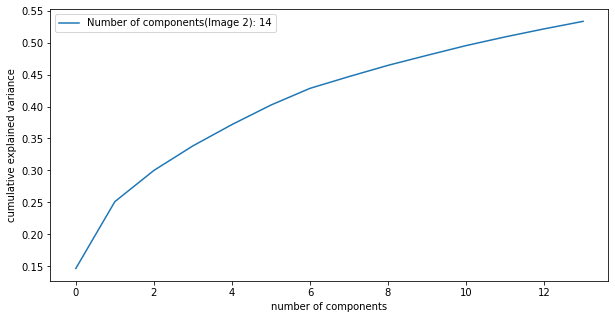

array([0.14643344, 0.10461054, 0.04886296, 0.03847045, 0.03336883,
       0.03059562, 0.02611566, 0.01844484, 0.01762134, 0.01565628,
       0.01525416, 0.01360734, 0.01258444, 0.01178929, 0.01093209],
      dtype=float32)


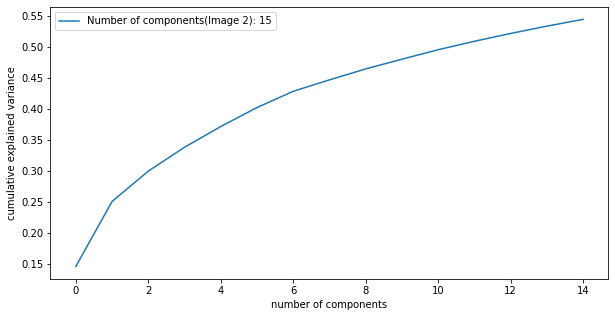

array([0.1464333 , 0.10461073, 0.0488629 , 0.03847046, 0.03336883,
       0.03059558, 0.02611564, 0.01844488, 0.01762135, 0.01565634,
       0.01525447, 0.01360809, 0.01258479, 0.01180057, 0.01093465,
       0.01070462], dtype=float32)


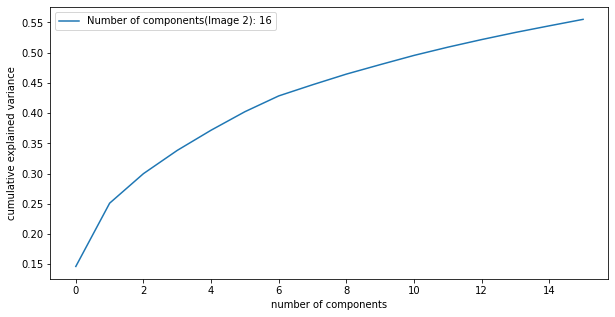

array([0.1464333 , 0.10461058, 0.04886292, 0.03847042, 0.03336879,
       0.03059558, 0.02611564, 0.01844488, 0.01762133, 0.01565636,
       0.0152545 , 0.01360811, 0.01258524, 0.01180076, 0.01093603,
       0.01070793, 0.01034266], dtype=float32)


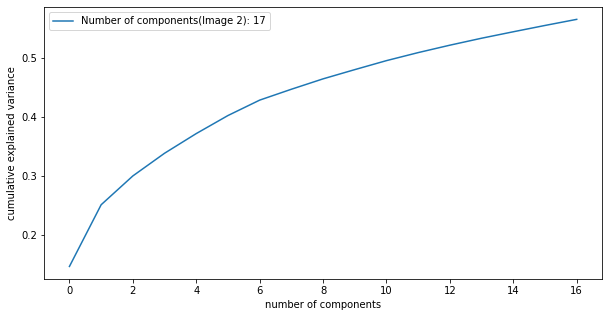

array([0.14643326, 0.10461073, 0.0488629 , 0.03847041, 0.0333688 ,
       0.03059556, 0.02611564, 0.0184449 , 0.01762133, 0.01565634,
       0.0152545 , 0.01360811, 0.01258504, 0.0118008 , 0.01093585,
       0.01070722, 0.01034264, 0.00978979], dtype=float32)


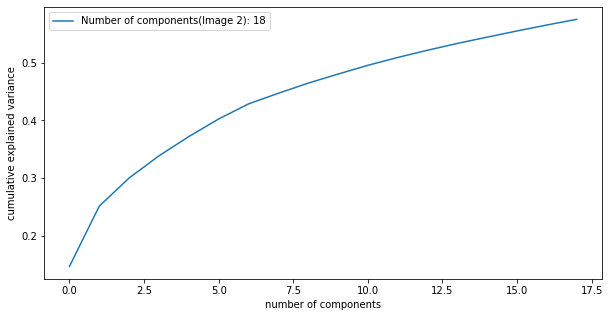

array([0.14643349, 0.10461067, 0.04886289, 0.03847049, 0.03336879,
       0.03059556, 0.02611566, 0.01844488, 0.01762133, 0.01565636,
       0.0152545 , 0.01360814, 0.01258518, 0.0118008 , 0.01093614,
       0.01070837, 0.01034296, 0.00979047, 0.00936587], dtype=float32)


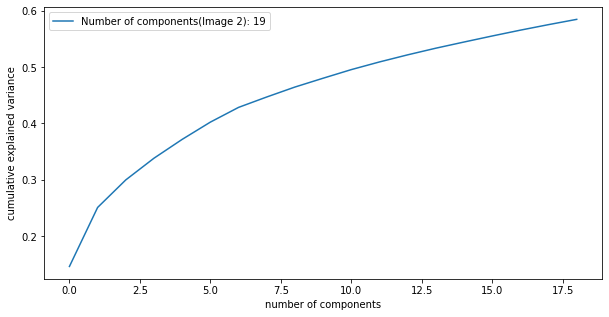

array([0.18795045], dtype=float32)


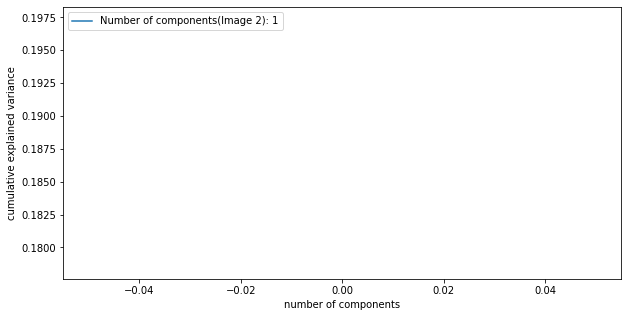

array([0.1879505 , 0.08392157], dtype=float32)


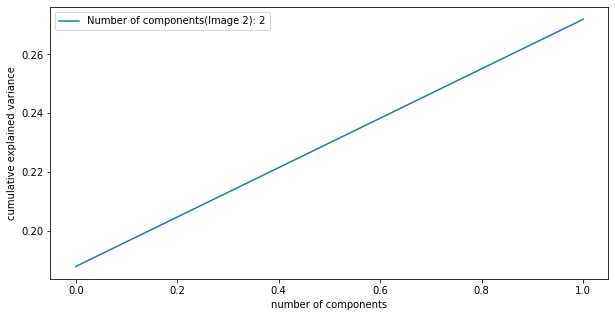

array([0.18795055, 0.08392159, 0.04517725], dtype=float32)


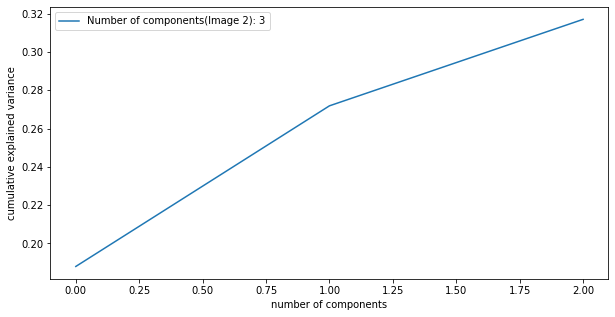

array([0.18795045, 0.08392155, 0.04517728, 0.03426037], dtype=float32)


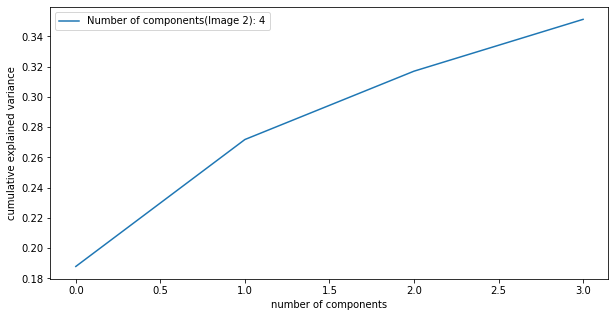

array([0.18795042, 0.0839216 , 0.04517728, 0.03426043, 0.03095194],
      dtype=float32)


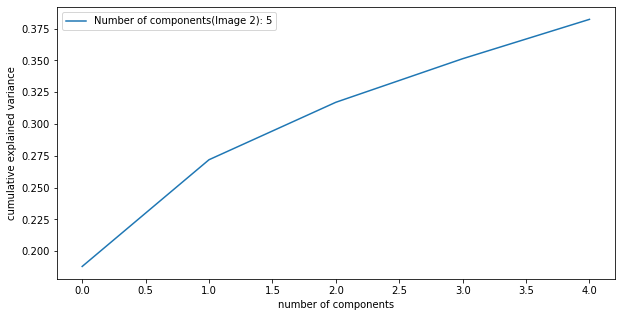

array([0.18795045, 0.08392159, 0.0451773 , 0.03426043, 0.03095198,
       0.02967949], dtype=float32)


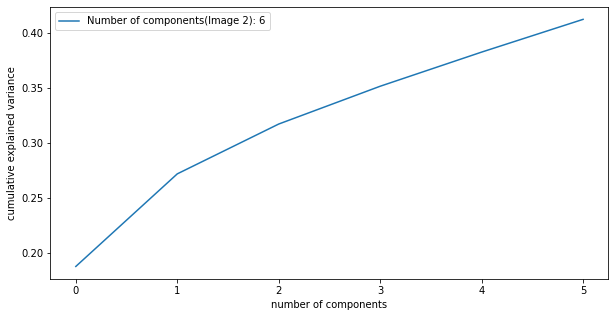

array([0.18795045, 0.0839216 , 0.04517731, 0.03426047, 0.03095194,
       0.02967948, 0.02354569], dtype=float32)


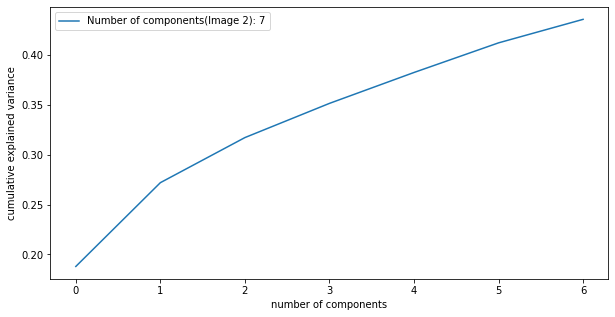

array([0.18795042, 0.0839216 , 0.04517732, 0.03426041, 0.03095196,
       0.02967947, 0.02354568, 0.01993591], dtype=float32)


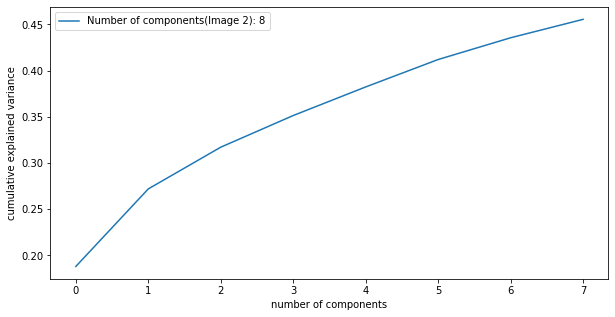

array([0.1879505 , 0.0839216 , 0.04517728, 0.03426041, 0.03095193,
       0.02967948, 0.02354568, 0.01993591, 0.01774407], dtype=float32)


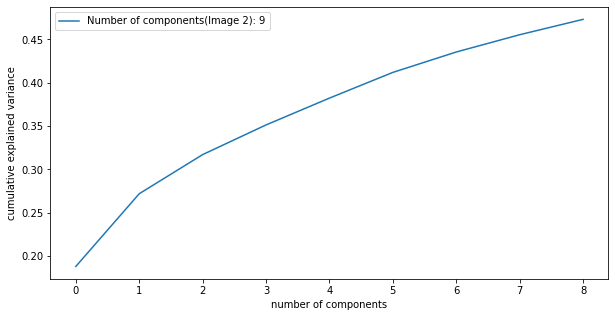

array([0.18795045, 0.08392157, 0.0451773 , 0.03426045, 0.03095193,
       0.02967945, 0.02354568, 0.01993591, 0.01774405, 0.01587577],
      dtype=float32)


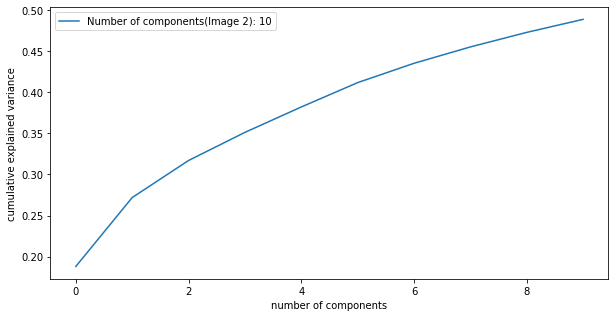

array([0.18795045, 0.0839216 , 0.04517728, 0.0342604 , 0.03095196,
       0.02967953, 0.02354567, 0.01993592, 0.01774406, 0.01587585,
       0.01412525], dtype=float32)


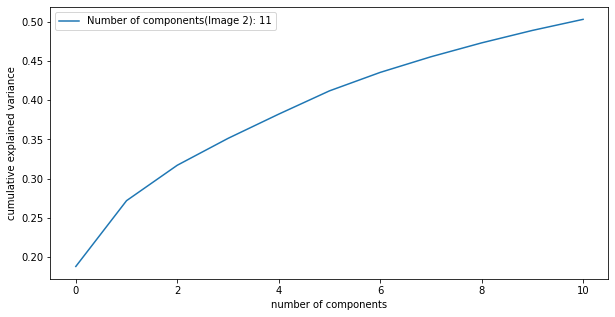

array([0.18795048, 0.08392154, 0.04517731, 0.03426044, 0.03095197,
       0.02967951, 0.0235457 , 0.01993595, 0.01774408, 0.01587591,
       0.01412532, 0.01374432], dtype=float32)


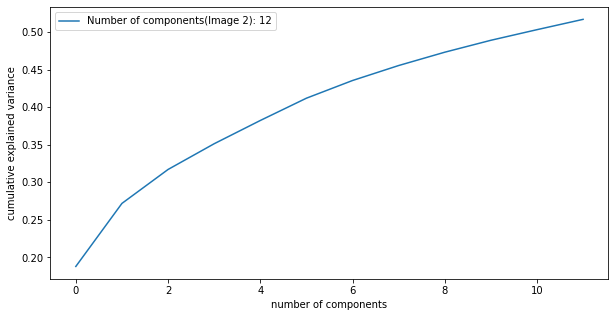

array([0.1879504 , 0.0839216 , 0.04517728, 0.03426047, 0.03095194,
       0.02967946, 0.02354569, 0.01993591, 0.01774408, 0.01587592,
       0.01412538, 0.01374475, 0.01207449], dtype=float32)


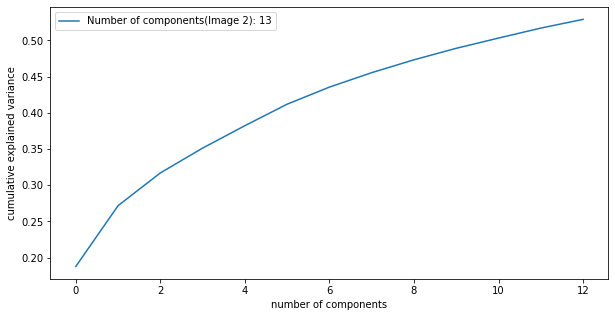

array([0.1879506 , 0.08392164, 0.0451773 , 0.03426041, 0.03095191,
       0.0296795 , 0.02354572, 0.01993594, 0.01774408, 0.01587592,
       0.01412537, 0.01374479, 0.01207489, 0.01070767], dtype=float32)


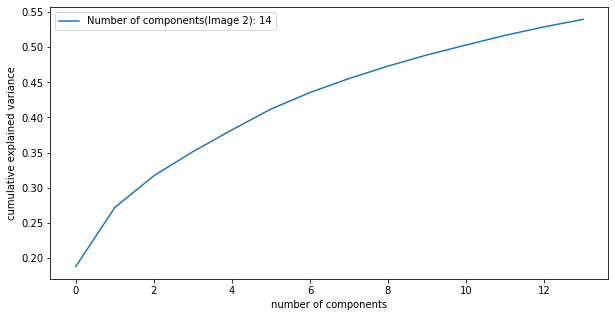

array([0.1879504 , 0.08392157, 0.04517728, 0.03426044, 0.030952  ,
       0.02967943, 0.02354569, 0.01993592, 0.01774408, 0.01587594,
       0.01412536, 0.01374476, 0.01207449, 0.01070776, 0.01022795],
      dtype=float32)


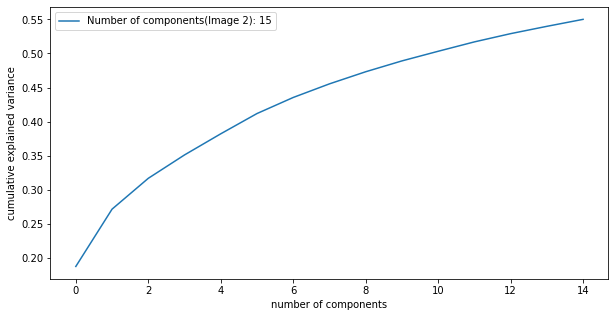

array([0.18795042, 0.08392157, 0.04517731, 0.03426041, 0.03095196,
       0.02967947, 0.02354571, 0.01993592, 0.01774409, 0.01587593,
       0.01412539, 0.01374475, 0.01207497, 0.01070789, 0.01022912,
       0.00995144], dtype=float32)


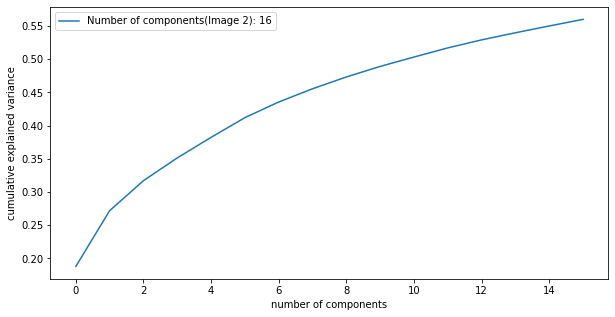

array([0.18795048, 0.0839216 , 0.04517732, 0.03426041, 0.03095199,
       0.02967946, 0.02354573, 0.01993593, 0.01774406, 0.01587594,
       0.0141254 , 0.01374478, 0.01207504, 0.01070782, 0.0102303 ,
       0.00995238, 0.00928843], dtype=float32)


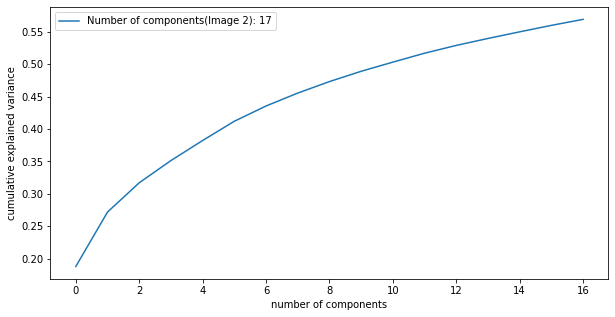

array([0.18795042, 0.08392153, 0.0451773 , 0.03426041, 0.03095198,
       0.02967945, 0.0235457 , 0.01993592, 0.01774405, 0.01587594,
       0.01412539, 0.01374477, 0.01207506, 0.01070796, 0.01023024,
       0.00995238, 0.00928857, 0.0086276 ], dtype=float32)


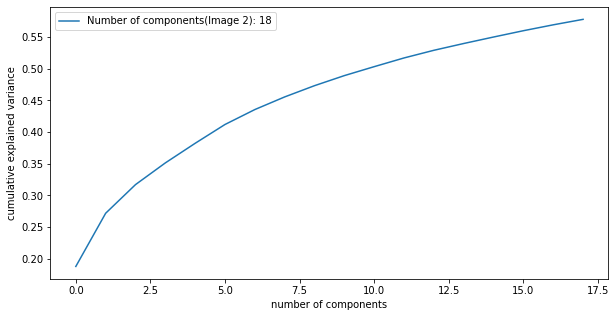

array([0.1879504 , 0.08392159, 0.04517727, 0.03426041, 0.03095201,
       0.02967946, 0.02354569, 0.01993593, 0.01774408, 0.01587595,
       0.01412539, 0.01374476, 0.01207508, 0.01070791, 0.01023008,
       0.00995226, 0.00928926, 0.00862988, 0.00839338], dtype=float32)


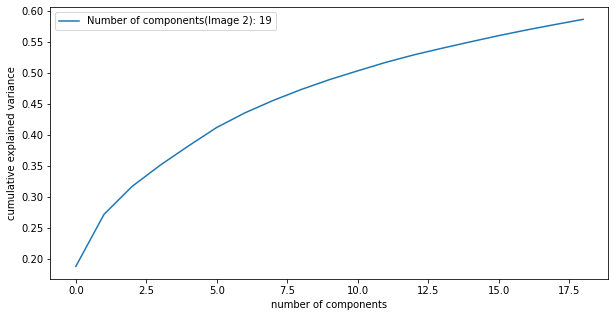

array([0.17899308], dtype=float32)


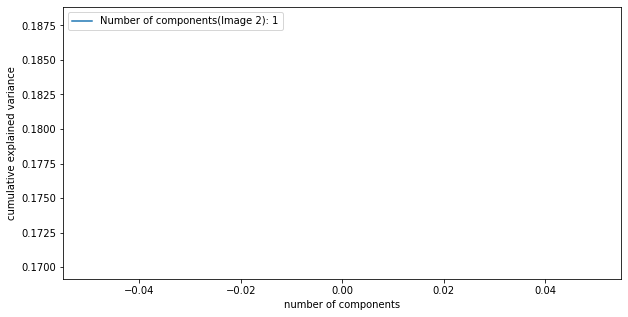

array([0.17899309, 0.08497361], dtype=float32)


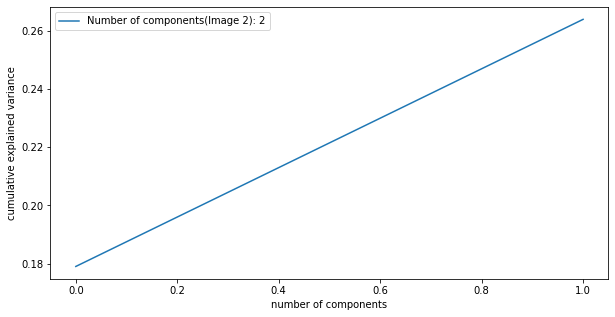

array([0.17899302, 0.08497366, 0.04494506], dtype=float32)


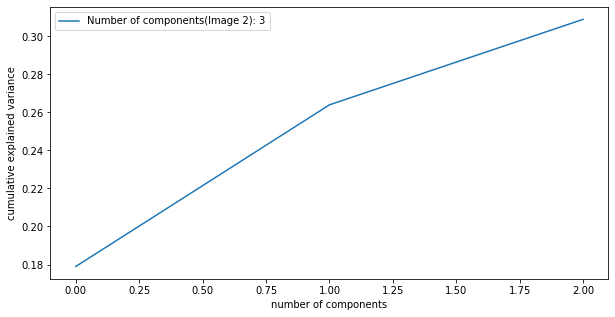

array([0.1789932 , 0.08497357, 0.04494498, 0.03420706], dtype=float32)


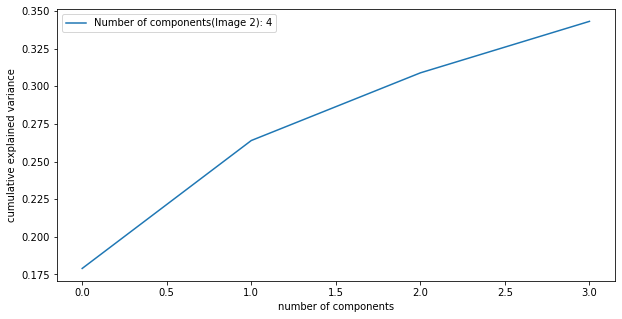

array([0.17899305, 0.0849736 , 0.04494504, 0.03420707, 0.03117168],
      dtype=float32)


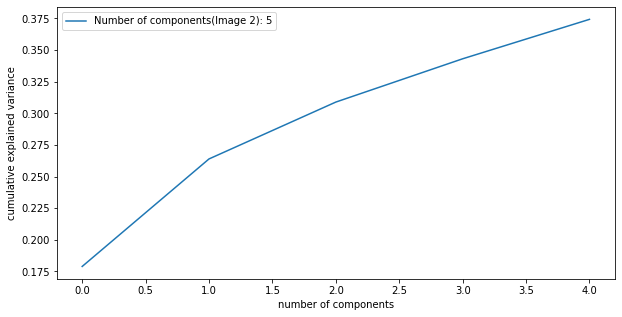

array([0.17899308, 0.0849736 , 0.04494504, 0.03420702, 0.03117164,
       0.03016319], dtype=float32)


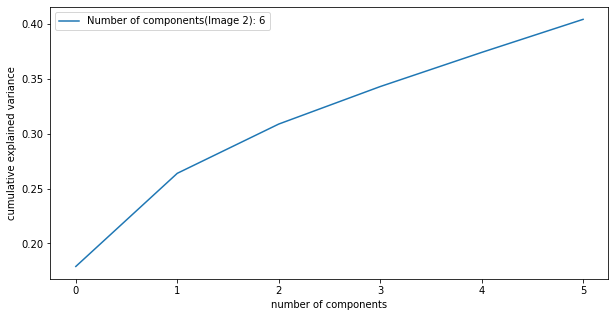

array([0.17899309, 0.08497357, 0.04494501, 0.03420706, 0.03117168,
       0.0301632 , 0.02235815], dtype=float32)


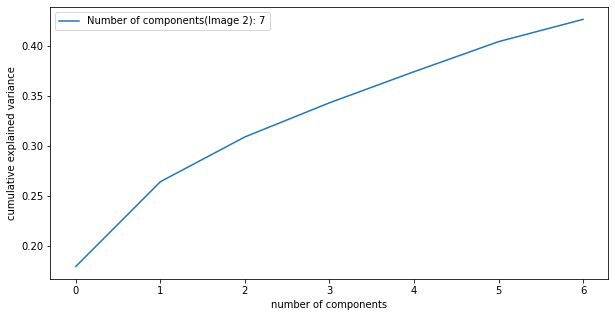

array([0.17899312, 0.08497366, 0.04494501, 0.03420704, 0.03117163,
       0.0301632 , 0.02235815, 0.01919876], dtype=float32)


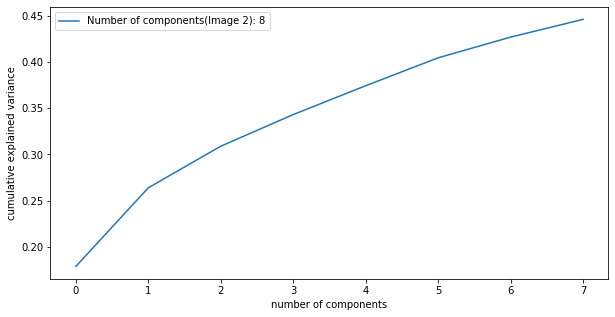

array([0.17899305, 0.08497358, 0.04494501, 0.03420704, 0.03117167,
       0.03016318, 0.02235812, 0.01919876, 0.0174655 ], dtype=float32)


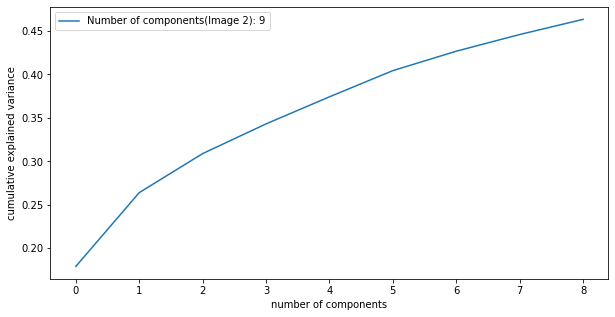

array([0.17899309, 0.08497366, 0.04494502, 0.03420714, 0.0311717 ,
       0.03016322, 0.02235814, 0.01919871, 0.01746543, 0.01638551],
      dtype=float32)


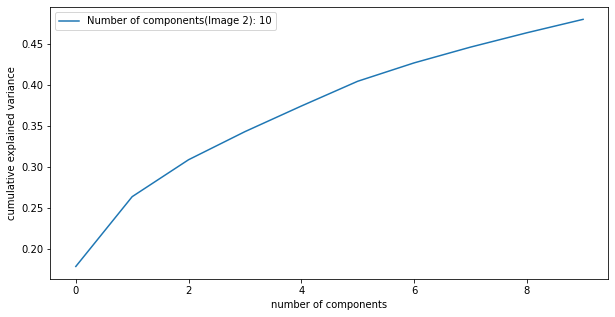

array([0.17899315, 0.0849736 , 0.04494499, 0.03420708, 0.03117171,
       0.0301632 , 0.02235815, 0.01919875, 0.01746548, 0.01638549,
       0.01416965], dtype=float32)


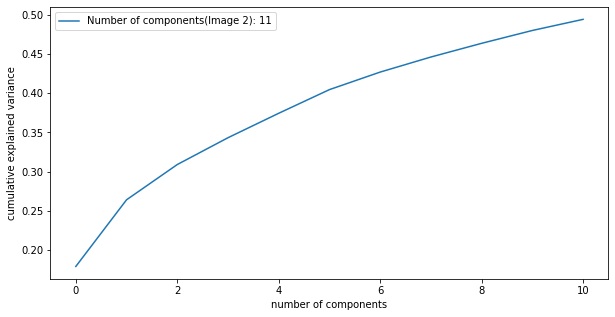

array([0.17899308, 0.0849736 , 0.04494504, 0.03420706, 0.03117168,
       0.03016324, 0.02235816, 0.01919877, 0.01746547, 0.01638539,
       0.0141699 , 0.01355392], dtype=float32)


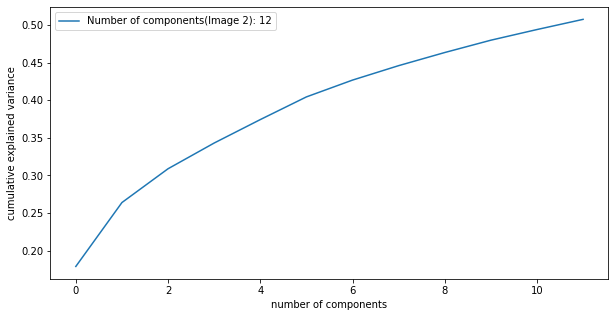

array([0.17899305, 0.08497358, 0.04494504, 0.03420707, 0.03117169,
       0.0301632 , 0.02235817, 0.01919877, 0.01746549, 0.01638551,
       0.01417001, 0.01355521, 0.01198696], dtype=float32)


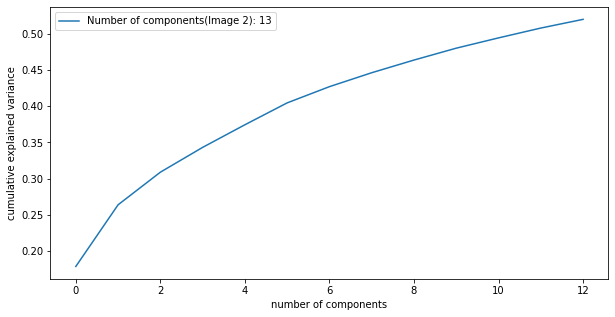

array([0.17899308, 0.08497361, 0.04494502, 0.03420712, 0.03117172,
       0.03016326, 0.02235816, 0.01919878, 0.01746549, 0.0163855 ,
       0.01416998, 0.01355533, 0.01198801, 0.01033844], dtype=float32)


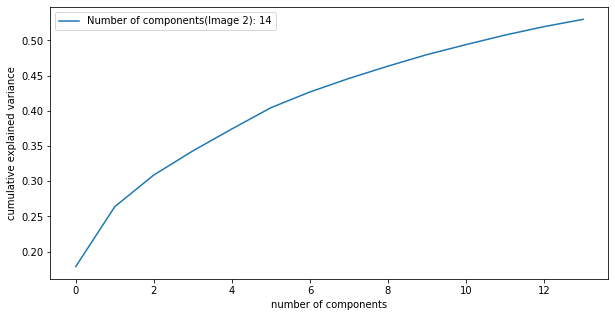

array([0.17899308, 0.08497363, 0.04494505, 0.03420706, 0.03117168,
       0.03016319, 0.02235815, 0.01919874, 0.01746548, 0.01638552,
       0.01417   , 0.01355541, 0.01198758, 0.01033625, 0.01025941],
      dtype=float32)


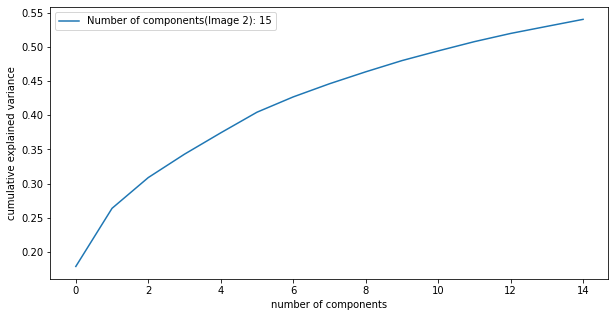

array([0.17899308, 0.08497366, 0.04494498, 0.03420709, 0.03117168,
       0.03016322, 0.02235817, 0.01919877, 0.01746552, 0.01638551,
       0.01417001, 0.01355551, 0.01198803, 0.01034278, 0.01026297,
       0.00982779], dtype=float32)


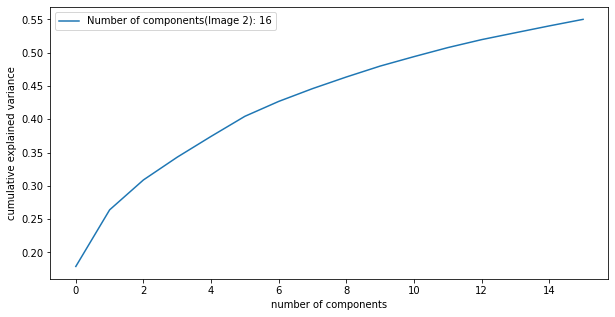

array([0.17899284, 0.08497369, 0.04494503, 0.03420708, 0.03117169,
       0.03016322, 0.02235814, 0.01919878, 0.0174655 , 0.01638554,
       0.01417002, 0.01355546, 0.01198803, 0.01034264, 0.01026337,
       0.00982992, 0.00968944], dtype=float32)


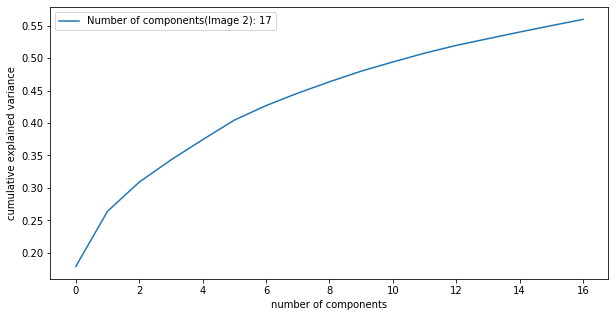

array([0.17899302, 0.0849736 , 0.04494498, 0.03420706, 0.03117168,
       0.03016322, 0.02235817, 0.01919875, 0.0174655 , 0.01638552,
       0.01417003, 0.01355549, 0.01198808, 0.01034288, 0.01026355,
       0.00983037, 0.00968919, 0.00883706], dtype=float32)


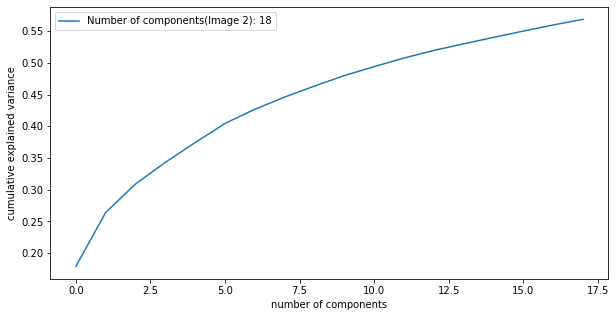

array([0.17899305, 0.08497369, 0.04494496, 0.03420709, 0.03117168,
       0.03016323, 0.02235813, 0.01919874, 0.01746547, 0.01638553,
       0.01417002, 0.01355546, 0.01198806, 0.01034289, 0.01026362,
       0.00983062, 0.00969003, 0.0088398 , 0.00865418], dtype=float32)


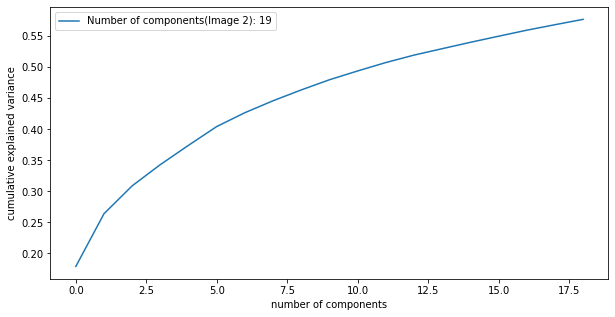

In [188]:
import pprint;pp = pprint.PrettyPrinter()
for dfs in [poi_df_vectors, normal_people_df_vectors, master_df_vectors]:
  for components in range(1,20):
    pca_model = _fit_pca(dfs, components)
    pp.pprint(pca_model.explained_variance_ratio_)
    _scree_plot(pca_model.explained_variance_ratio_)

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin, silhouette_samples, silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram


def _fit_kmeans(data, n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(data)
    kmeans_coords = kmeans.fit_transform(data)
    kmeans_centers = kmeans.cluster_centers_
    # Compute minimum distances between one point and a set of points.
    labels = pairwise_distances_argmin(data, kmeans_centers)
    # Silhouette analysis     
    _get_silhouette_score(data, labels, n_clusters)
    # CH Index    
    _get_ch_index(data, labels, n_clusters)
    # plotting
    plt.scatter(kmeans_coords[:, 0], kmeans_coords[:, 1], c=labels)
    plt.title("KMeans- #clusters (%.2g )" % n_clusters)
    plt.show()
    return kmeans_coords


def _get_ch_index(data, labels, n_clusters):
    """
    The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.
    
    input: 
        data : feature matrix
        labels: labels from clustering algorithm  
        n_clusters: Clustered segments
    output: prints the calinski_harabasz_score
    """
    
    ch_index = calinski_harabasz_score(data, labels)
    print("For n_clusters =", n_clusters,
          "The CH score is :", ch_index)

def _get_silhouette_score(data, labels, n_clusters):
    """
    Silhouette analysis can be used to study the separation distance between the resulting clusters.
    Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from 
    the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary 
    between two neighboring clusters and negative values indicate that those samples might have been assigned to
    the wrong cluster.
    
    input: 
        data : feature matrix
        labels: labels from clustering algorithm  
        n_clusters: Clustered segments
    output: prints the silhouette_score
    """
    
    silhouette_avg = silhouette_score(data, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
def _fit_hierarchical_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit(data)
    # Compute minimum distances between one point and a set of points.
    labels =clustering.labels_
    # Silhouette analysis     
    _get_silhouette_score(data, labels, n_clusters)
    # CH Index    
    _get_ch_index(data, labels, n_clusters)
    # plotting
    plt.figure(figsize=(10,10))
    plt.title("Hierarchical Clustering Dendrogram #clusters (%.2g )" % n_clusters)
    plot_dendrogram(clustering, labels=clustering.labels_)
    plt.show()

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

For n_clusters = 2 The average silhouette_score is : 0.41570085
For n_clusters = 2 The CH score is : 4.7361295004657284


RecursionError: ignored

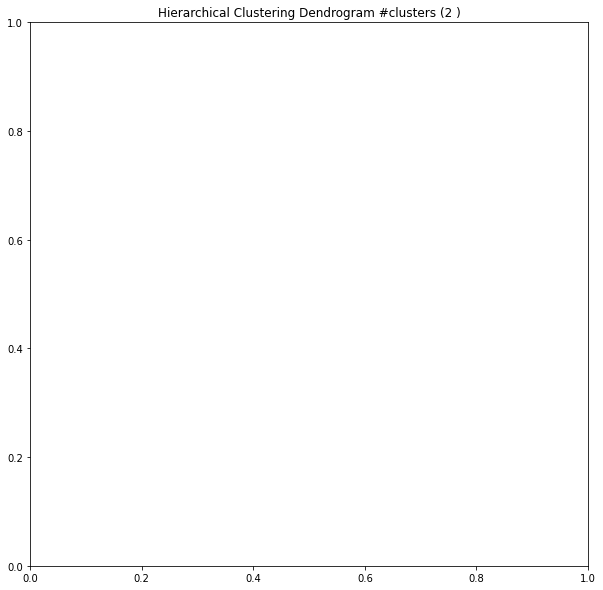

In [190]:
segments = [2,3,4,5]

# for dfs in [poi_df_vectors, normal_people_df_vectors, master_df_vectors]:
for x in segments:
    _fit_hierarchical_clustering(master_df_vectors, x)

In [79]:
poi_sent_df

,Unnamed: 0,e_id,email_body,subject_line,user
2883,2883,_129.subject,Dave The PPA schedule was pushed back two we...,Notification of Postponement,lavorato-j
2884,2884,_140.subject,The Emmisions book under Kevin McGowan will ta...,Emmisions,lavorato-j
2885,2885,_146.subject,Please excuse Kim Hillis and Kay Chapman from ...,SAP Timekeeping Class,lavorato-j
2886,2886,_147.subject,This memo follows up on our discussion this mo...,VAR,lavorato-j
2887,2887,_166.subject,"This is to confirm a meeting for tomorrow, Tue...",System Meeting 7/11,lavorato-j
...,...,...,...,...,...
5567,5567,_91.subject,"Ladies and gentlemen of Class #64, Jeff Skill...",Astros Game,skilling-j
5568,5568,_93.subject,"Mark, Jeff asked me to let you know that John ...",Enron Europe,skilling-j
6337,6337,_17.subject,"Joe, I have slotted you 90 minutes w/Greg on ...",Meeting Confirmation,whalley-g
6338,6338,_20.subject,"Hi Matthew, Greg will be in the London office...",Meeting Time w/Greg Whalley,whalley-g


In [81]:
normal_people.shape

(6296, 5)

(394, 768)

For n_clusters = 2 The average silhouette_score is : 0.4617629
For n_clusters = 2 The CH score is : 5.778919850048352


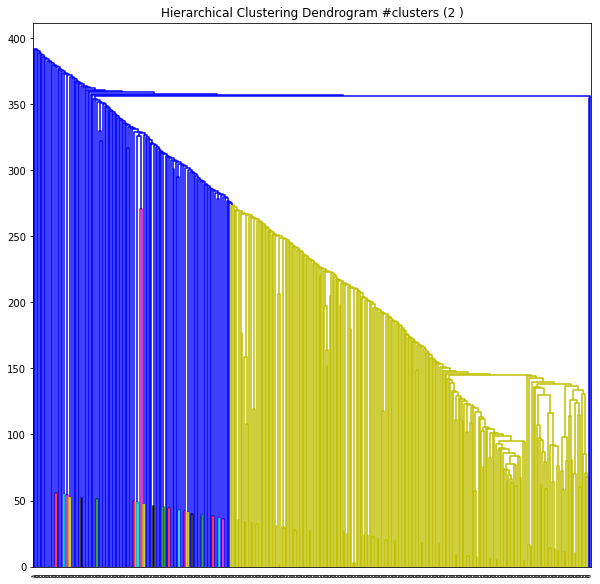

For n_clusters = 3 The average silhouette_score is : 0.33983067
For n_clusters = 3 The CH score is : 4.6807777891795945


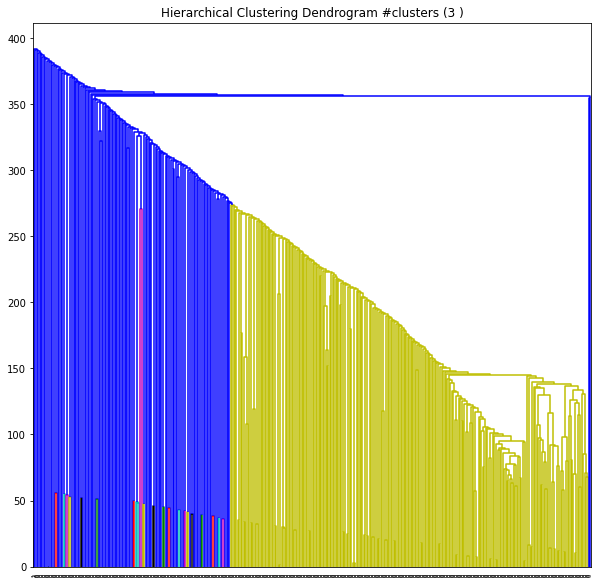

For n_clusters = 4 The average silhouette_score is : 0.33345136
For n_clusters = 4 The CH score is : 4.446169424602415


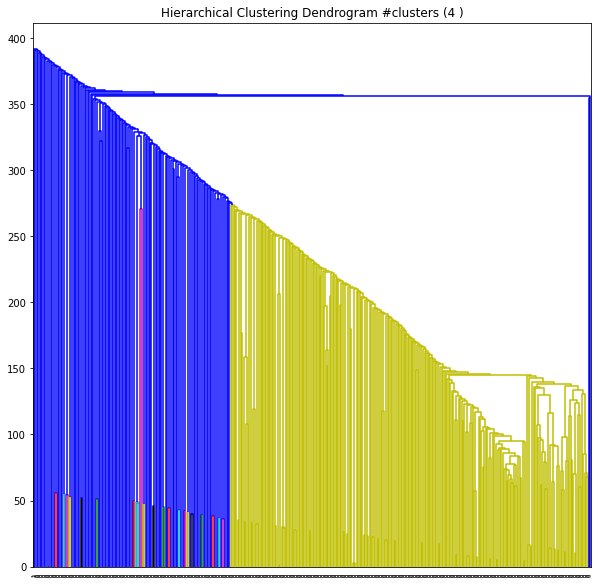

For n_clusters = 5 The average silhouette_score is : 0.26948687
For n_clusters = 5 The CH score is : 4.032683248035253


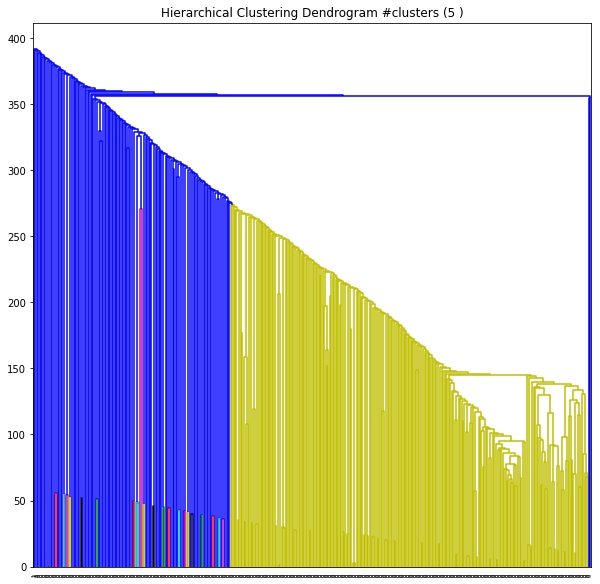

In [89]:
segments = [2,3,4,5]

for x in segments:
    _fit_hierarchical_clustering(normal_people_sent_vectors, x)

For n_clusters = 2 The average silhouette_score is : 0.10453674
For n_clusters = 2 The CH score is : 9.601509082185565


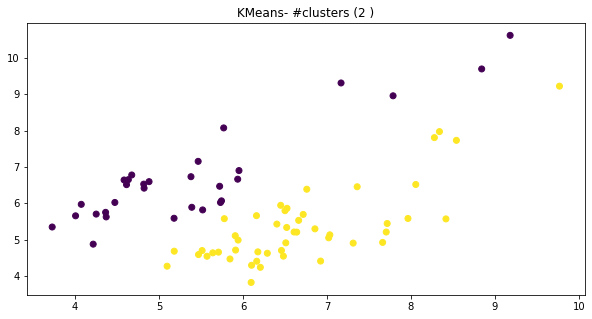

For n_clusters = 3 The average silhouette_score is : 0.09308732
For n_clusters = 3 The CH score is : 7.490631618307265


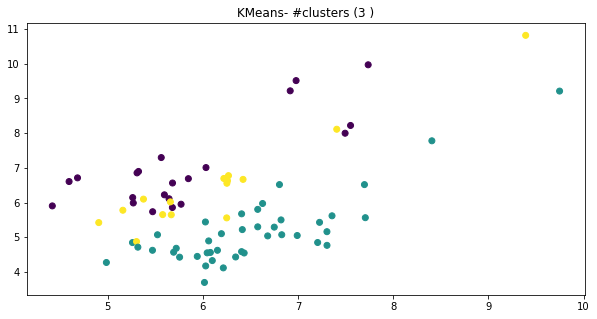

For n_clusters = 4 The average silhouette_score is : 0.07079791
For n_clusters = 4 The CH score is : 6.745813932160868


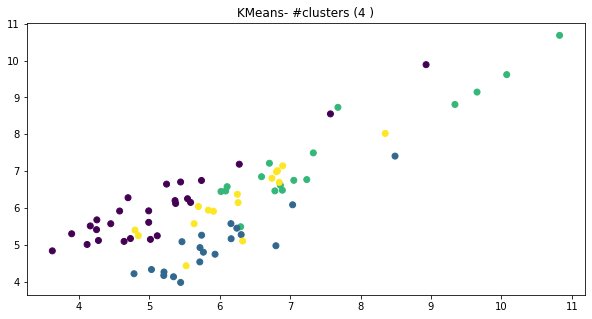

For n_clusters = 5 The average silhouette_score is : 0.0744967
For n_clusters = 5 The CH score is : 5.923246584573545


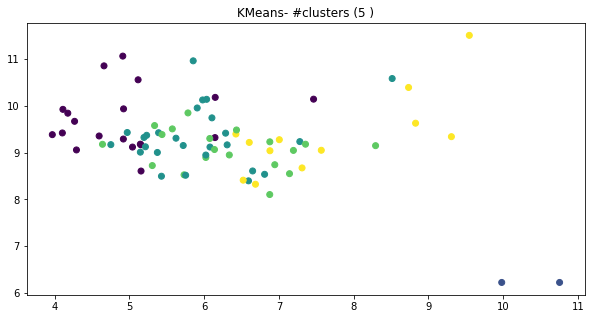

In [91]:
segments = [2,3,4,5]

for x in segments:
    _fit_kmeans(poi_sent_vectors, x)